In [72]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [73]:
#THis function is being used to calculate the statisticl parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the LR model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [74]:
#Function used to run the LR model
#train_dataset: Training dataset to train the model
#independent_var: Column names 
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on 
def log_reg(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the LR model
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=67)
        clf = LogisticRegression()
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs 
        Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return F1_Score, Accuracy_Values, test_demo_df, predicted_df

In [107]:
#Defining the columns and creating the Dataframe with all 1000 datapoints
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)
german_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   checking_account_status  1000 non-null   object 
 1   duration                 0 non-null      float64
 2   credit_history           0 non-null      float64
 3   purpose                  0 non-null      float64
 4   credit_amount            0 non-null      float64
 5   savings_account_status   0 non-null      float64
 6   employment_status        0 non-null      float64
 7   installment_rate         0 non-null      float64
 8   personal_status          0 non-null      float64
 9   other_debtors            0 non-null      float64
 10  residence_since          0 non-null      float64
 11  property                 0 non-null      float64
 12  age                      0 non-null      float64
 13  other_installment_plans  0 non-null      float64
 14  housing                  

In [76]:
#Encode all the non-numeric columns with dummies
encoded_data=pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker'], drop_first=True) 
encoded_data.info()
encoded_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   duration                      1000 non-null   int64 
 1   purpose                       1000 non-null   object
 2   credit_amount                 1000 non-null   int64 
 3   installment_rate              1000 non-null   int64 
 4   residence_since               1000 non-null   int64 
 5   age                           1000 non-null   int64 
 6   existing_credits              1000 non-null   int64 
 7   num_dependents                1000 non-null   int64 
 8   credit_risk                   1000 non-null   int64 
 9   checking_account_status_A12   1000 non-null   uint8 
 10  checking_account_status_A13   1000 non-null   uint8 
 11  checking_account_status_A14   1000 non-null   uint8 
 12  credit_history_A31            1000 non-null   uint8 
 13  credit_history_A32 

,duration,purpose,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependents,credit_risk,checking_account_status_A12,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,6,A43,1169,4,4,67,2,1,1,0,...,0,0,1,1,0,0,1,0,1,0
1,48,A43,5951,2,2,22,1,1,2,1,...,0,0,1,1,0,0,1,0,0,0
2,12,A46,2096,2,3,49,1,2,1,0,...,0,0,1,1,0,1,0,0,0,0
3,42,A42,7882,2,4,45,1,2,1,0,...,0,0,1,0,1,0,1,0,0,0
4,24,A40,4870,3,4,53,2,2,2,0,...,1,0,1,0,1,0,1,0,0,0


In [77]:
#Initialize all the different columns including predictors and target variable
encoded_data.columns
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12',
       'checking_account_status_A13', 'checking_account_status_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_account_status_A62',
       'savings_account_status_A63', 'savings_account_status_A64',
       'savings_account_status_A65', 'employment_status_A72',
       'employment_status_A73', 'employment_status_A74',
       'employment_status_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103',
       'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202']


In [78]:
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=67)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points 
#y_test contains the ground truth for each of the test data points

In [80]:
type(x_test)

numpy.ndarray

In [81]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf=5)
#clf = LogisticRegression()
log = clf.fit(x_train,y_train)
prediction = log.predict(x_test)

In [82]:
# 1 is good and 2 is bad 
log.classes_

array([1, 2])

              precision    recall  f1-score   support

           1       0.78      0.83      0.80       139
           2       0.54      0.46      0.50        61

    accuracy                           0.71       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.70      0.71      0.71       200

[[115  24]
 [ 33  28]]
Accuracy of the model on Testing Sample Data: 0.71


ValueError: Found input variables with inconsistent numbers of samples: [800, 1000]

In [84]:
#Break the test dataframe into different groups
#Unprotected group is everyone <45
#Complement group is everyone >= 45
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['credit_risk_12'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['age']<45]))
total_priv = (len(concat_df[concat_df['age']>=45]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] < 45)])
total_credit_priv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] >= 45)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')


Statistical Parity: -0.03322


In [85]:
print(len(test_demo_df))
print(len(predicted_df))

print(total_unpriv)
print(total_priv)

print(total_credit_priv)
print(total_credit_unpriv)

200
200
156
44
40
147


In [86]:
#Combine x_train and y_train
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

#print(train_full_df)

In [87]:
print(len(train_full_df))

800


In [88]:
#File to write the information to
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate shenanigans
#Implement label flipping and recalculate
list_parity = []
list_num = []
list_flip = []

for index, row in train_full_df.iterrows():
    if row['credit_risk'] == 1:
        train_full_df.at[index, 'credit_risk'] = 2
        
        accuracy, multi_accuracy, test_datapoints, test_prediction = log_reg(train_full_df, predictors, target_var, 'credit_risk_12')
        
        list_flip.append(index)
        list_num.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        list_parity.append(parity)

        train_full_df.at[index,'credit_risk'] = 1
    
    elif row['credit_risk'] == 2:
        train_full_df.at[index, 'credit_risk'] = 1
        
        accuracy, multi_accuracy, test_datapoints, test_prediction = log_reg(train_full_df, predictors, target_var, 'credit_risk_12')
        list_flip.append(index)
        list_num.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        list_parity.append(parity)

        train_full_df.at[index,'credit_risk'] = 2
        
        
        
    


In [89]:
parity_difference = []
large_influence = []
large_influence_negative = []
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list 
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)

print(len(parity_difference)) 

#Rows are considered to be high influence if they fall in between .03, -.03
for index, item in enumerate(parity_difference):
    if item <= .03 or item >= -.03:
        large_influence.append(item)
        #print(f"Index: {index}, Item: {item}")
        li_row.append(index+1)








800


In [90]:
#This takes the absolute value of each of value of parity and then sorts it properly
#Using the first 150 values I will graph these
abs_sorted_list = sorted(zip(large_influence,li_row), key=lambda x: (abs(x[0]), -x[0]), reverse=True)
sorted_values, sorted_row_numbers= zip(*abs_sorted_list)

#sorted_data = sorted(zip(values, row_numbers), key=lambda x: (abs(x[0]), -x[0]), reverse=True)
#sorted_values, sorted_row_numbers = zip(*sorted_data)

print(sorted_values)
print(sorted_row_numbers)

(0.13331064646854118, 0.12579184947606004, 0.11883000040894776, 0.09683055735687318, 0.08875481243902295, 0.08179296337191078, 0.08179296337191078, 0.08179296337191078, 0.08123601544654169, 0.08067906752117282, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07371721845406054, 0.06814773920037076, 0.06675536938694837, 0.06675536938694837, 0.06675536938694837, 0.06675536938694837, 0.06619842146157928, 0.06062894220788961, 0.05979352031983609, 0.05979352031983609, 0.05979352031983609, 0.05979352031983609, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.053110145215408355, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051

In [91]:
#Get the top 150 values of the ranked list along with their index
top_sorted_li = sorted_values[:150]
top_sorted_li_index = sorted_row_numbers[:150]
print(top_sorted_li)
print(top_sorted_li_index)


(0.13331064646854118, 0.12579184947606004, 0.11883000040894776, 0.09683055735687318, 0.08875481243902295, 0.08179296337191078, 0.08179296337191078, 0.08179296337191078, 0.08123601544654169, 0.08067906752117282, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07427416637942952, 0.07371721845406054, 0.06814773920037076, 0.06675536938694837, 0.06675536938694837, 0.06675536938694837, 0.06675536938694837, 0.06619842146157928, 0.06062894220788961, 0.05979352031983609, 0.05979352031983609, 0.05979352031983609, 0.05979352031983609, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.05923657239446711, 0.053110145215408355, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.05227472332735483, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051717775401985966, 0.051

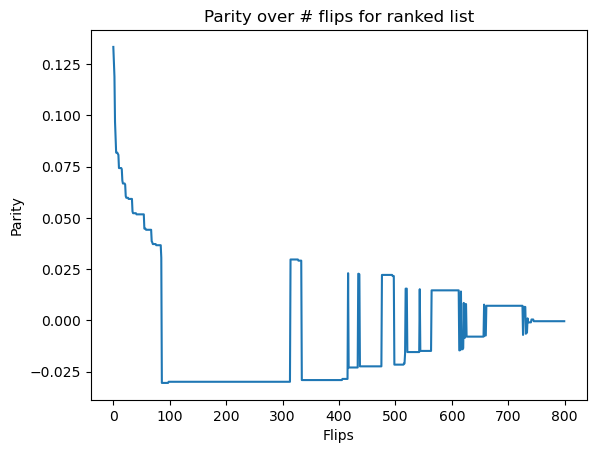

In [92]:
#Plot of the information in the order of the flips of parity
x=range(len(sorted_values))

#Plot the data
plt.plot(x,sorted_values)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

In [93]:
#Randomized flipping 
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'credit_risk'
budget = 150

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
for iter in range(budget):
    random_row = random.choice(train_full_df.index)
    if train_full_df.at[random_row,col_name] == 1:
        train_full_df.at[random_row,col_name] = 2

        accuracy, multi_accuracy, test_datapoints, test_prediction = log_reg(train_full_df, predictors, target_var,'credit_risk_12')
        
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        train_full_df.at[random_row,col_name] = 1
        
    elif train_full_df.at[random_row,col_name] == 2:
        train_full_df.at[random_row,col_name] = 1

        accuracy, multi_accuracy, test_datapoints, test_prediction = log_reg(train_full_df, predictors, target_var,'credit_risk_12')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        train_full_df.at[random_row,col_name] = 2




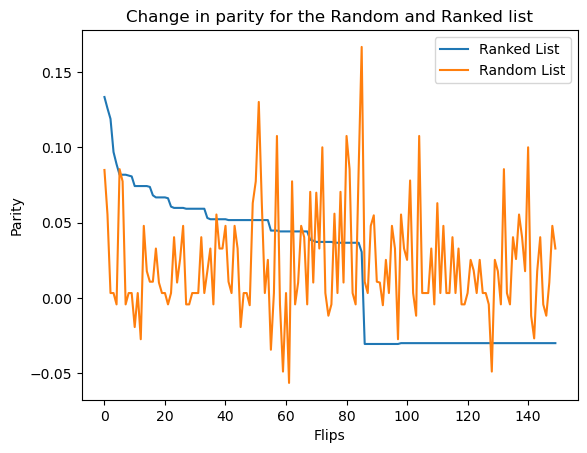

In [94]:
#Plotting the random flips dataset and the systematic flips 
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(top_sorted_li))
plt.plot(x,top_sorted_li,label='Ranked List')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()


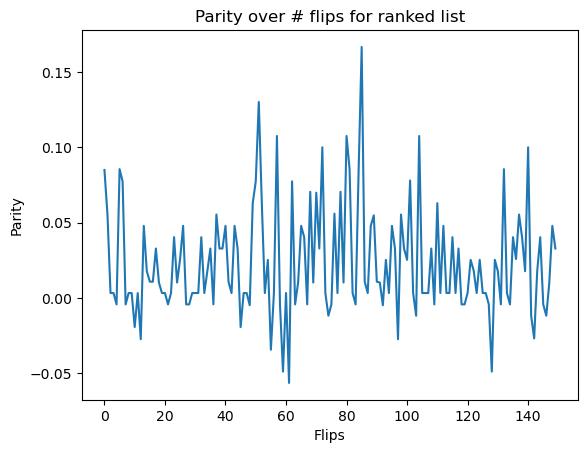

In [95]:
#Plot of the the changes in parity when randomly selecting points in the data
x=range(len(random_list_parity))

#Plot the data
plt.plot(x,random_list_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

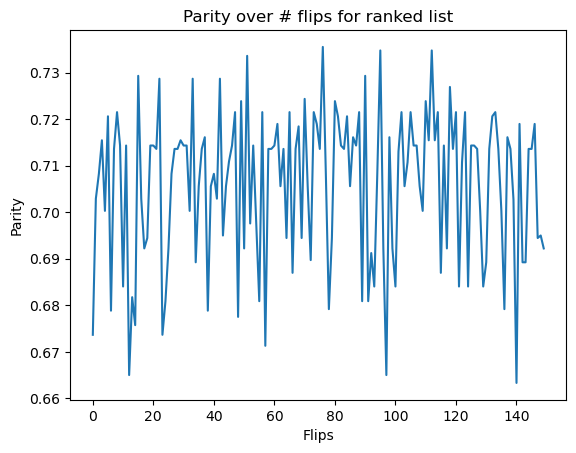

In [96]:
#Plot of the the changes in accuracy when randomly selecting points in the data
x=range(len(random_list_acc))

#Plot the data
plt.plot(x,random_list_acc)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

In [97]:
print(len(random_list_parity))

150


In [98]:
print(len(list_parity))
print(len(list_flip))
print(len(list_num))

800
800
800


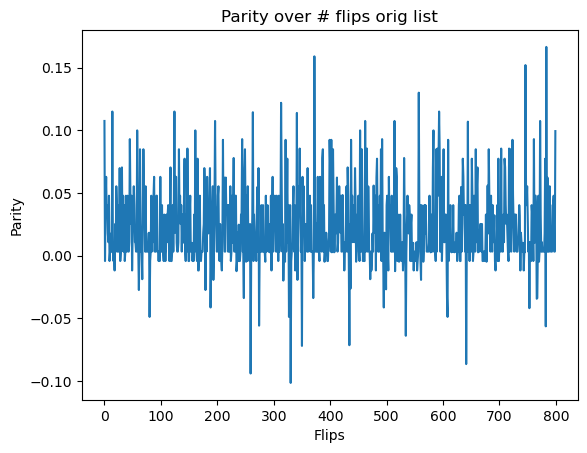

In [99]:
#Plot of the information in the order of the flips of parity
x=range(len(list_parity))

#Plot the data
plt.plot(x,list_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips orig list')

#Show the plot
plt.show()



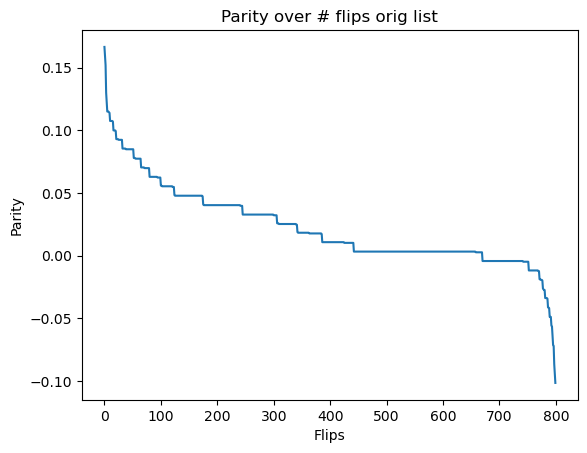

In [100]:
#Plot of the information in the order of the flips of parity
list_parity.sort(reverse=True)
x=range(len(list_parity))

#Plot the data
plt.plot(x,list_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips orig list')

#Show the plot
plt.show()

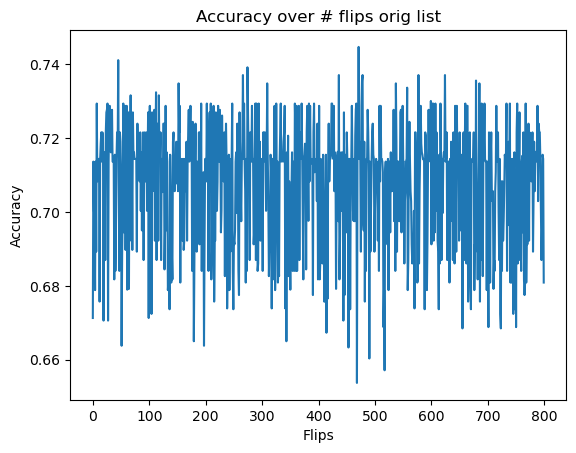

In [101]:
#Plot of the information in the order of descending 

#Create the x-axis
x=range(len(list_num))

#Plot the data
plt.plot(x,list_num)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Accuracy')
plt.title('Accuracy over # flips orig list')

#Show the plot
plt.show()


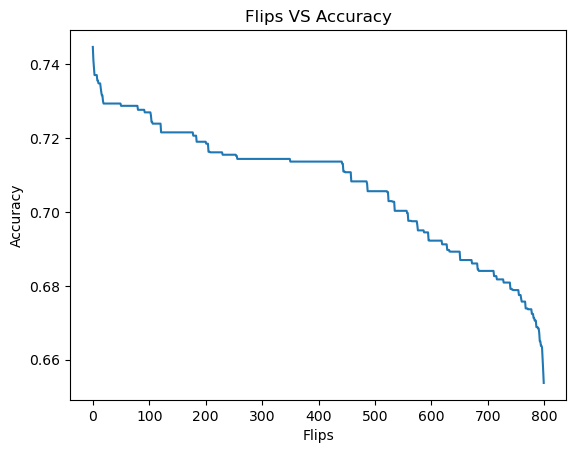

In [102]:
#Plot the information in descending order
list_num.sort(reverse=True)
#Create the x-axis
x=range(len(list_num))

#Plot the data
plt.plot(x,list_num)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Accuracy')
plt.title('Flips VS Accuracy')

#Show the plot
plt.show()

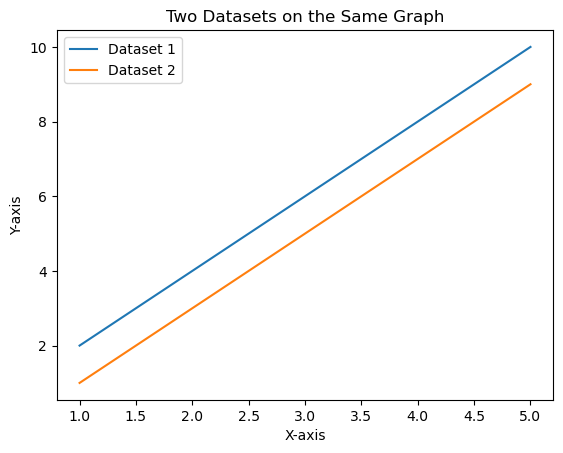

In [103]:

# Data for the first dataset
x1 = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]

# Data for the second dataset
x2 = [1, 2, 3, 4, 5]
y2 = [1, 3, 5, 7, 9]

# Plotting the first dataset
plt.plot(x1, y1, label='Dataset 1')

# Plotting the second dataset
plt.plot(x2, y2, label='Dataset 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Datasets on the Same Graph')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()






